### What are partial dependence plots?

In Machine learning there is a recurrent dilemma between performance and interpretation. More complex models usually result in better performance but can black-boxy and hard to interpret. Simpler models like Linear Regression have a straight forward interpretation but tend to suffer from inflexibility. Partial dependence plots (PDPs) help visualize and quanitify the relationship between features and predicted outcomes. They are are particularly helpful with black-box models like Random Forests, Gradient Boosted Trees, Neural Networks where interpretability is an issue. 

PDPs provide a way to look at the directionality of feature(s) with respect to the predicted outcome. Though ensemble methods like random forests and gradient boosted trees give us a way to measure *importance* of features that give a sense of which
features tend to have the most effect on the variability of the outcome, they don't give a way to measure the directionality. 
For exampe, how does one understand and quanitify the change in a feature on the predicted outcome? Is the change linear or monotonic or possbily non-linear and non-monotonic? In what direction does changing a feature value change the outcome and how? Understanding and quantifying the effect of changing drivers on the outcome is a natural and an important question, and allows for causal interpretation for black-box models

***Partial dependence plots, introduced by Friedman in 2001, can help in interpreting complex machine learning algorithms by quantifying the directionaity of relationship between the outcome and features.***

PDPs help visualize the relationship between a subset of features (typically 1-2) and the response, while accounting for the *average* effect of the other predictors in the model. 

***`sklearn` currently (as of Feb 2019) implements partial dependence plots only for gradient boosted trees.
The goal of this project is to extend sklearn's partial dependence functionality to any classifer and any regressor.***

### How does the algorithm work?

The algorithm is deceptively simple. 

Let $x_1$ be the predictor of interest with unique values $\{x_{11}, x_{12}, ...,x_{1l} \}$. Partial dependence plot for $x_1$ is constructed as follows. 

For $i \in \{1, 2,..,l \}$, 

*Step 1* 

a. Copy the training data and replace the original values of $x_1$ with $x_{1i}$

b. Compute the vector of predicted values from the modified copy of the training data. 

c. Compute the average of this vector to obtain the partial dependence function $\bar{f}(x_1)$. 

*Step 2*

Plot the pairs $(x_i, \bar{f}(x_i))$ for $i=1, 2,..l$

### Few words of caution

In the above algorithm, we can take multiple features and compute the partial dependence function for these features. Taking one feature gives a 1-dimensional curve. Due to limitations of human perception we can take at most 2 features for producing partial dependence plots. 

Note that this requires a pass over the data for each set of joint values of training data or which the partial dependence 
function is to be evaluated. This can be computationally intensive. (However, with decision trees partial dependence function can be quickly evaluated from the trees themselves without reference to the data, which is why `sklearn` currently implements
partial dependence function only for gradient boosted trees.)

Also note that partial dependence functions represent the effect of the feature $X_i$ on the prediction *after accounting for the average effects of other variables on the prediction. They are not the effects of $X_i$ on prediction ignoring the effects of other variables.*

### Example 1

We will use the California housing dataset as an example and walk through the API use to see how partial dependence plots can help in interpretation for regression and classification models. In this first example we will fit two classifiers and try to infer trends from partial dependence plots

In [1]:
# Boilerplate 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets.california_housing import fetch_california_housing
from sklearn.metrics import confusion_matrix, classification_report

# Create a dataframe with target variable as the median price label, which takes 3 values 'low', 'medium' and 'high'

cal_housing = fetch_california_housing()
df = pd.DataFrame(data=cal_housing.data, columns=cal_housing.feature_names)
df['price_cat'] = pd.qcut(cal_housing.target, q=3, labels=['low', 'medium', 'high'])

# Train test split
features = df.drop("price_cat", axis=1)
labels = df["price_cat"]

features_train, features_test, labels_train, labels_test = train_test_split(features, 
                                                                            labels, 
                                                                            test_size=0.2, 
                                                                            random_state=42,
                                                                            stratify=labels)

In [2]:
# Fit a classifer
print("Training GBC...")
gbc = GradientBoostingClassifier(loss='deviance',
                                 n_estimators=150, 
                                 max_depth=4,
                                 learning_rate=0.1,
                                 random_state=1)
gbc.fit(features_train, labels_train)
print("Done")

print(' GBC:\n {}\n'.format(classification_report(labels_test, gbc.predict(features_test))))
confusion_matrix(labels_test, gbc.predict(features_test))

Training GBC...
Done
 GBC:
               precision    recall  f1-score   support

        high       0.88      0.83      0.85      1376
         low       0.86      0.86      0.86      1377
      medium       0.73      0.77      0.75      1375

   micro avg       0.82      0.82      0.82      4128
   macro avg       0.82      0.82      0.82      4128
weighted avg       0.82      0.82      0.82      4128




array([[1141,   16,  219],
       [  16, 1187,  174],
       [ 145,  177, 1053]], dtype=int64)

In [3]:
# Fit another classifier
print("Training RF...")
rf = RandomForestClassifier(random_state=0)
rf.fit(features_train, labels_train)
print("Done")

print(' RF:\n {}\n'.format(classification_report(labels_test, rf.predict(features_test))))
confusion_matrix(labels_test, rf.predict(features_test))

Training RF...


C:\Users\karth\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Done
 RF:
               precision    recall  f1-score   support

        high       0.82      0.83      0.83      1376
         low       0.83      0.86      0.84      1377
      medium       0.71      0.67      0.69      1375

   micro avg       0.79      0.79      0.79      4128
   macro avg       0.79      0.79      0.79      4128
weighted avg       0.79      0.79      0.79      4128




array([[1140,   22,  214],
       [  24, 1184,  169],
       [ 221,  229,  925]], dtype=int64)

Now that the classifiers have been fit we can select a feature and the label for which the partial 
dependence function is to be calculated. Since the performance of classifiers is decent we can trust the results of 
the partial dependence plots. (In classification problems the 'prediction' is the probability of belonging to a class.
For plotting we also need to specify the label for which the partial dependence plot is to be drawn.)

In [4]:
feature_name = 'HouseAge'
label_name = 'high'

In [5]:
# Instatiate the PartialDependence object
partial_dependence_rf = partial_dependence.PartialDependence(model=rf,                                                             
                                                             feature_name=feature_name,
                                                             training_df=features_train,
                                                             percentile=(0.05, 0.95),
                                                             n_grid=1000)

Calculating partial dependence function
Finished
Plotting partial dependence function for the given label


Text(0.5,0,'HouseAge')

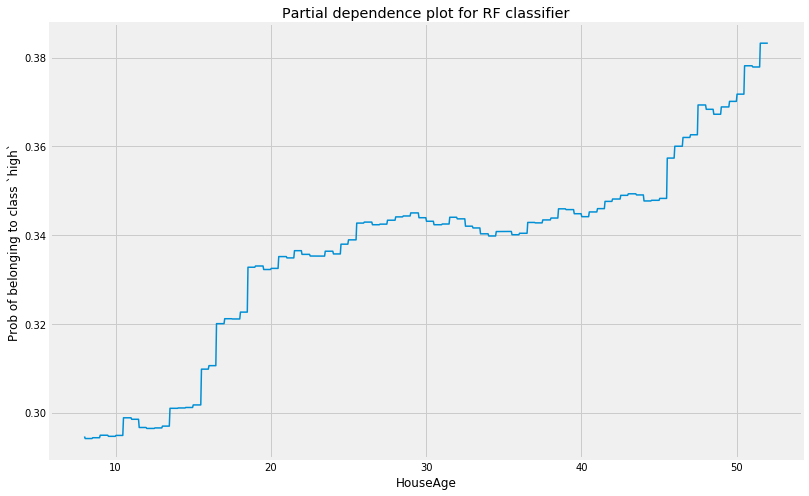

In [6]:
# Calculate and plot the partial dependence plot
fig, ax = partial_dependence_rf.plot_partial_dependence(label=label_name)
#fig, ax = partial_dependence_rf.plot_partial_dependence() # <- Okay; plots for the first label
#fig, ax = partial_dependence_rf.plot_partial_dependence(label=2) # <- Okay
#fig, ax = partial_dependence_rf.plot_partial_dependence(label=6) # <- gives an error since model has only 3 classes
ax.set_title('Partial dependence plot for RF classifier')
ax.set_ylabel('Prob of belonging to class `{}`'.format(label_name))
ax.set_xlabel(feature_name)

In [7]:
# Gradient boosted model
partial_dependence_gbc = partial_dependence.PartialDependence(model=gbc,
                                                              feature_name=feature_name,
                                                              training_df=features_train,
                                                              percentile=(0.05, 0.95),
                                                              n_grid=1000)

Calculating partial dependence function
Finished
Plotting partial dependence function for the given label


Text(0.5,0,'HouseAge')

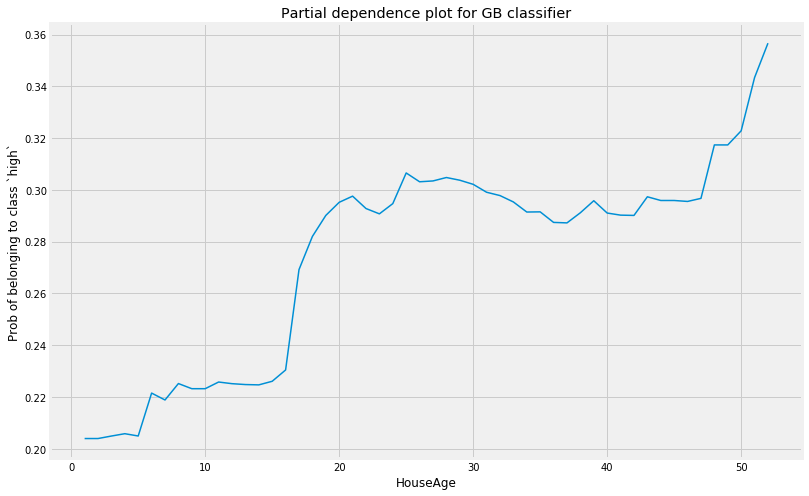

In [8]:
fig, ax = partial_dependence_gbc.plot_partial_dependence(label=label_name)
#fig, ax = partial_dependence_gbc.plot_partial_dependence(label=1)
ax.set_title('Partial dependence plot for GB classifier')
ax.set_ylabel('Prob of belonging to class `{}`'.format(label_name))
ax.set_xlabel(feature_name)

### How do we interpret these plots?

Both the plots caculate the probability of belonging to a particular label as the target feature
(`HouseAge`) increases and takes 1000 (`n_grid`) equally spaced values between 5-95 percentile. 

The plots for both the models show similar trend. As the value of the target feature `HouseAge` there is a higher probability of belonging to the class `high`. Or in other words we can conclude:
***Increase in HouseAge results in a higher median price for the house*** Partial Dependence plots can thus help in quantifying the effect of changing a variable on the predicted outcome. 

**TL;DR:** The partial dependence plots depend on the model which has been fit, and better the predictive ability of the model, the more confident we can be about inferring correct trends from the plots.

### Example 2
In this example we will fit two regressors and try to infer trends from the partial dependence plots. 

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

In [10]:
# Load Data
cal_housing = fetch_california_housing()
df_reg = pd.DataFrame(data=cal_housing.data, columns=cal_housing.feature_names)
features = df_reg
labels = cal_housing.target

# Train test split
features_train, features_test, labels_train, labels_test = train_test_split(features, 
                                                                            labels, 
                                                                            test_size=0.2, 
                                                                            random_state=42)

In [11]:
# Fit a regressor
print("Training RF regressor...")
reg_rf = RandomForestRegressor(n_estimators=10, 
                                 max_depth=None,
                                 random_state=1)
reg_rf.fit(features_train, labels_train)
print("Done")
r2_score(reg_rf.predict(features_test), labels_test)

Training RF regressor...
Done


0.749447835393372

In [12]:
# Fit another regressor
print("Training GB regressor...")
reg_gb = GradientBoostingRegressor(loss='ls',
                                   n_estimators=1500,
                                   random_state=1
                                   )
reg_gb.fit(features_train, labels_train)
print("Done")
r2_score(reg_gb.predict(features_test), labels_test)

Training GB regressor...
Done


0.8029531601248057

Now that the regressors have been fit we can select a feature for which the partial 
dependence function is to be calculated. Since the performance of regressors is decent we can trust the results of 
the partial dependence plots. (Since the models predict the actual outcome there is no need to specify any label name.)

In [13]:
feature_name ='HouseAge'

In [14]:
partial_dependence_reg_rf = partial_dependence.PartialDependence(model=reg_rf,
                                                                 feature_name=feature_name,
                                                                 training_df=features_train,
                                                                 percentile=(0.05, 0.99),
                                                                 n_grid=1000)

Calculating partial dependence function
Finished
Plotting partial dependence function for the given label


Text(0.5,0,'HouseAge')

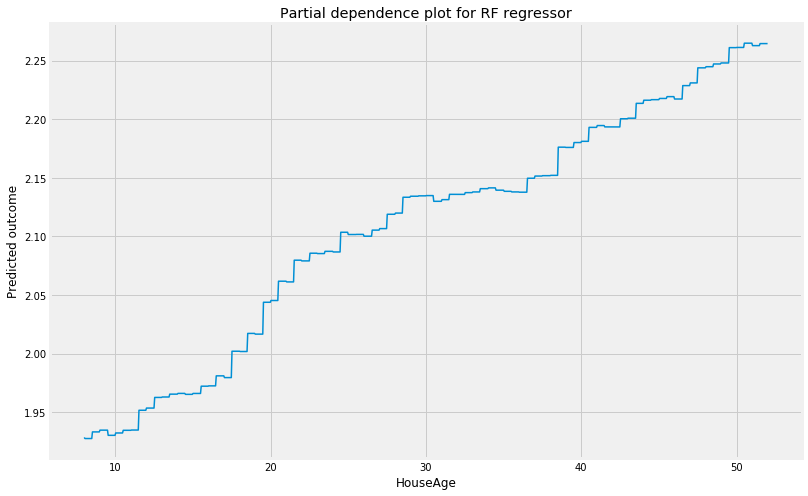

In [15]:
fig, ax = partial_dependence_reg_rf.plot_partial_dependence(label=0) # Okay
#fig, ax = partial_dependence_reg_rf.plot_partial_dependence(label=0) # Okay, label defaults to 0
#fig, ax = partial_dependence_reg_rf.plot_partial_dependence(label=2) # Not okay, for regression models label=0
ax.set_title('Partial dependence plot for RF regressor')
ax.set_ylabel('Predicted outcome')
ax.set_xlabel(feature_name)

In [16]:
partial_dependence_reg_gb = partial_dependence.PartialDependence(model=reg_gb,
                                                                 feature_name=feature_name,
                                                                 training_df=features_train,
                                                                 percentile=(0.05, 0.95),
                                                                 n_grid=1000)

Calculating partial dependence function
Finished
Plotting partial dependence function for the given label


Text(0.5,0,'HouseAge')

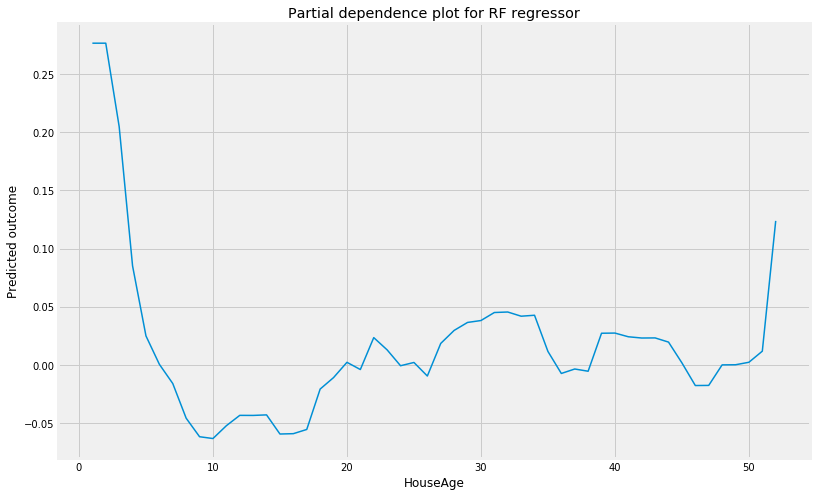

In [17]:
fig, ax = partial_dependence_reg_gb.plot_partial_dependence()
ax.set_title('Partial dependence plot for RF regressor')
ax.set_ylabel('Predicted outcome')
ax.set_xlabel(feature_name)

***Wait, why is there a difference in the y axis values for the regressor plots?***

We notice similar trends in partial dependence plots for both the models. An increase in `HouseAge` results in decrease of the predicted outcome. Note that the y-axis for the random forest plot is positive but the y-axis for the Gradient Boosted model
dips below zero. This is because the predicted function in both the cases is different. *For gradient boosted model, I used 
sklearn's implementation which subtracts the mean from the final result, while for the random forest model the predicted function is calculated from scratch and no such subtraction takes place.

### Future work

There are 4 key features that could make this project more robust and applicable. In order of increasing difficulty they are:

1. ***Write unit tests.*** Definitely need to add unit tests.

2. **Adding functionality for contour plots.** 
    Currently we only plot 1D partial dependence plots. An improvement would be to add contour plot functionality, wherein
    one coud look at the effect of changing two variables on the predicted outcome. 

3. ***Adding option for standard deviations.*** Include error bars in the plots. 

4. ***Adding other algorithms.*** Partial dependence plots are global in nature. They use all of training data
    to calculate the partial dependence function. We could add other algorithms which are more local in nature (like what the package LIME does)
    
